# Fine Tune Stable Diffusion

Fine tuning Stable Diffusion on Pokemon, 
for more details see the [Lambda Labs examples repo](https://github.com/LambdaLabsML/examples). 

We recommend using a multi-GPU machine, for example an instance from [Lambda GPU Cloud](https://lambdalabs.com/service/gpu-cloud). If running on Colab this notebook is likely to need a GPU with >16GB of VRAM and a runtime with high RAM, which will almost certainly need Colab Pro or Pro+. (If you get errors suchs as `Killed` or `CUDA out of memory` then one of these is not sufficient)

In [1]:
# !git clone https://github.com/justinpinkney/stable-diffusion.git
# %cd stable-diffusion
# !pip install --upgrade pip
# !pip install -r requirements.txt

# !pip install --upgrade keras # on lambda stack we need to upgrade keras
# !pip uninstall -y torchtext # on colab we need to remove torchtext

In [2]:
!nvidia-smi

Wed Dec 20 00:09:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A40          Off  | 00000000:01:00.0 Off |                    0 |
|  0%   68C    P0   280W / 300W |  44887MiB / 46068MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A40          Off  | 00000000:25:00.0 Off |                    0 |
|  0%   

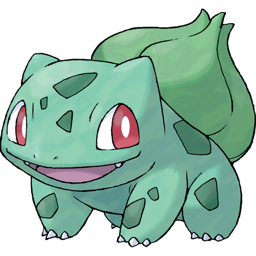

a drawing of a green pokemon with red eyes


In [4]:
# Check the dataset
import os

# from datasets import load_dataset
# ds = load_dataset('lambdalabs/pokemon-blip-captions', split='train')
# ds.save_to_disk('datasets/hf/pokemon')

from datasets import load_from_disk
ds = load_from_disk("/mnt/homes/minghao/AI/final_project/datasets/hf/pokemon")

sample = ds[0]
display(sample['image'].resize((256, 256)))
print(sample['text'])

To get the weights you need to you'll need to [go to the model card](https://huggingface.co/CompVis/stable-diffusion-v1-4-original), read the license and tick the checkbox if you agree.

In [ ]:
# !pip install huggingface_hub
# from huggingface_hub import notebook_login

# notebook_login()

: 

In [5]:
from huggingface_hub import hf_hub_download
ckpt_path = hf_hub_download(repo_id="CompVis/stable-diffusion-v-1-4-original", filename="sd-v1-4-full-ema.ckpt", use_auth_token=True)

LocalTokenNotFoundError: Token is required (`token=True`), but no token found. You need to provide a token or be logged in to Hugging Face with `huggingface-cli login` or `huggingface_hub.login`. See https://huggingface.co/settings/tokens.

Set your parameters below depending on your GPU setup, the settings below were used for training on a 2xA6000 machine, (the A6000 has 48GB of VRAM). On this set up good results are achieved in around 6 hours.

You can make up for using smaller batches or fewer gpus by accumulating batches:

`total batch size = batach size * n gpus * accumulate batches`

In [6]:
# 2xA6000:
BATCH_SIZE = 4
N_GPUS = 2
ACCUMULATE_BATCHES = 1

gpu_list = ",".join((str(x) for x in range(N_GPUS))) + ","
print(f"Using GPUs: {gpu_list}")

Using GPUs: 0,1,


In [10]:
# Run training
import os

os.system('''
          
          python /mnt/homes/minghao/AI/final_project/src/main.py \
    --train \
    --base "/mnt/homes/minghao/AI/final_project/src/configs/stable-diffusion/sd-image-condition-attn-finetune_mural.yaml" \
    --gpus "0,1,2,3,4,5,6,7" \
    --scale_lr False \
    --num_nodes 1 \
    --check_val_every_n_epoch 10 \
    --finetune_from "/mnt/homes/minghao/AI/final_project/pretrained_weights/sd-v1-4-full-ema.ckpt" \
    data.params.batch_size=2 \
    lightning.trainer.accumulate_grad_batches=4
          
          ''')




# !(python main.py \
#     --train \
#     --base "configs/stable-diffusion/pokemon.yaml" \
#     --gpus "0,1,2,3" \
#     --scale_lr False \
#     --num_nodes 1 \
#     --check_val_every_n_epoch 10 \
#     --finetune_from "/mnt/homes/minghao/AI/final_project/pretrained_weights/sd-v1-4-full-ema.ckpt" \
#     data.params.batch_size=4 \
#     lightning.trainer.accumulate_grad_batches=1
# )

Global seed set to 23


Running on GPUs 0,1,2,3
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
Keeping EMAs of 688.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.19.self_attn.k_proj.bias', 'vision_model.encoder.layers.13.self_attn.q_proj.weight', 'vision_model.encoder.layers.20.self_attn.k_proj.weight', 'vision_model.encoder.layers.22.layer_norm1.weight', 'vision_model.encoder.layers.17.self_attn.out_proj.weight', 'vision_model.encoder.layers.8.self_attn.k_proj.weight', 'vision_model.encoder.layers.14.layer_norm1.weight', 'vision_model.encoder.layers.9.mlp.fc2.weight', 'vision_model.encoder.layers.0.mlp.fc2.bias', 'vision_model.encoder.layers.9.self_attn.q_proj.weight', 'vision_model.encoder.layers.16.self_attn.v_proj.weight', 'vision_model.encoder.layers.2.layer_norm1.weight', 'vision_model.encoder.layers.23.layer_norm2.weight', 'vision_model.encoder.layers.2.self_attn.q_proj.weight', 'vision_model.encoder.layers.6.layer_norm1.bias', 'vision_model.encoder.layers.21.mlp.fc1.weight', 'vision_model.enc

Attempting to load state from /mnt/homes/minghao/AI/final_project/pretrained_weights/sd-v1-4-full-ema.ckpt
Found nested key 'state_dict' in checkpoint, loading this instead
Monitoring val/loss as checkpoint metric.
Merged modelckpt-cfg: 
{'target': 'pytorch_lightning.callbacks.ModelCheckpoint', 'params': {'dirpath': 'logs/2023-12-20T00-12-51_pokemon/checkpoints', 'filename': '{epoch:06}', 'verbose': True, 'save_last': True, 'monitor': None, 'save_top_k': -1, 'every_n_train_steps': 2000}}


/mnt/homes/minghao/anaconda3/envs/ldm/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:432: UserWarning: ModelCheckpoint(save_last=True, save_top_k=None, monitor=None) is a redundant configuration. You can save the last checkpoint with ModelCheckpoint(save_top_k=None, monitor=None).
  rank_zero_warn(
ModelCheckpoint(save_last=True, save_top_k=-1, monitor=None) will duplicate the last checkpoint saved.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


)0PuDB 2019.2 - ?:help  n:next  s:step into  b:breakpoint  !:python command line[PROCESSING EXCEPTION - hit 'e' to examine]  1198                     if isinstance(             Variables:  1199                         e,                     combined_path: 'lambdalabs  1200                         (                        /pokemon-blip-captions/p  1201                             OfflineModeIsEnabl   okemon-blip-captions.py'  1202                             requests.exception data_dir: None  1203                             requests.exception data_files: None  1204                         ),                     download_config: DownloadC  1205                     ):                         Stack:> 1206                         raise ConnectionError( >> dataset_module_factory  1207                     elif "404" in str(e):      >> dataset_module_factory  1208                         msg = f"Dataset '{path    load_dataset_builder lo  1209                         raise FileN

In [ ]:
# Run the model
!(python scripts/txt2img.py \
    --prompt 'robotic cat with wings' \
    --outdir 'outputs/generated_pokemon' \
    --H 512 --W 512 \
    --n_samples 4 \
    --config 'configs/stable-diffusion/pokemon.yaml' \
    --ckpt 'path/to/your/checkpoint')

: 